In [ ]:
# default_exp models.ph

# Piecewise Hazard Model
> How to estimate the Piecewise Hazard estimator.

In this module we assume that during a given time period the hazard is constant.

In [ ]:
# export
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MaxAbsScaler

torch.Tensor.ndim = property(lambda x: x.dim())

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
class PieceWiseHazard(nn.Module):
    """
    Piecewise Hazard where the hazard is constant between breakpoints.
    parameters:
    - breakpoints: time points where hazard would change (must include 0 and max possible time)
    """
    def __init__(self, breakpoints:np.array, t_scaler:MaxAbsScaler, **kwargs):
        super().__init__()
        self.t_scaler = t_scaler
        if len(breakpoints.shape) == 1:
            breakpoints = self.t_scaler.transform(breakpoints[:,None])
        else:
            breakpoints = self.t_scaler.transform(breakpoints)
        self.logλ = nn.Parameter(torch.randn(len(breakpoints)-1, 1))
        self.register_buffer('breakpoints', torch.Tensor(breakpoints[:-1]))
        self.register_buffer('widths', torch.Tensor(np.diff(breakpoints, axis=0)))
        self.prepend_zero = nn.ConstantPad2d((0,0,1,0), 0)
        
    def cumulative_hazard(self, t, t_section):
        """
        Integral of hazard wrt time.
        """
        λ = torch.exp(self.logλ)

        # cumulative hazard 
        cum_hazard = λ * self.widths
        cum_hazard = cum_hazard.cumsum(0)
        cum_hazard = self.prepend_zero(cum_hazard)
        cum_hazard_sec = cum_hazard[t_section]
        
        δ_t = t - self.breakpoints[t_section]
        
        return cum_hazard_sec + λ[t_section] * δ_t
        
    def forward(self, t, t_section, *args):
        return self.logλ[t_section], self.cumulative_hazard(t, t_section)
    
    def survival_function(self, t:np.array):
        """
        parameters:
        - t: time (do not scale to be between 0 and 1)
        """
        if len(t.shape) == 1:
            t = t[:,None]
        t = self.t_scaler.transform(t)
            
        with torch.no_grad():
            # get the times and time sections for survival function
            breakpoints = self.breakpoints[1:].cpu().numpy()
            t_sec_query = np.searchsorted(breakpoints.squeeze(), t.squeeze())
            # convert to pytorch tensors
            t_query = torch.Tensor(t)
            t_sec_query = torch.LongTensor(t_sec_query)

            # calculate cumulative hazard according to above
            Λ = self.cumulative_hazard(t_query, t_sec_query)
            return torch.exp(-Λ)
        
    def hazard(self):
        with torch.no_grad():
            width = self.widths
            breakpoints = self.breakpoints
            λ = torch.exp(self.logλ)
            return (self.t_scaler.inverse_transform(breakpoints).squeeze(), 
                    self.t_scaler.inverse_transform(width).squeeze(), 
                    λ.squeeze())
            
    def plot_survival_function(self, t):
        s = self.survival_function(t)
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, s)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()
        
    def plot_hazard(self):
        """
        Plot base hazard
        """
        breakpoints, width, λ = self.hazard()
        # plot
        plt.figure(figsize=(12,5))
        plt.bar(breakpoints, λ, width, align='edge')
        plt.ylabel('λ')
        plt.xlabel('t')
        plt.show()

In [ ]:
# hide
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/rossi.csv"
df = pd.read_csv(url)
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


epoch,train_loss,valid_loss,time
0,1.798062,#na#,00:00
1,1.798095,#na#,00:00
2,1.795559,#na#,00:00
3,1.794856,#na#,00:00
4,1.793225,#na#,00:00
5,1.793375,#na#,00:00
6,1.796378,#na#,00:00
7,1.796837,#na#,00:00
8,1.796736,#na#,00:00
9,1.798183,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


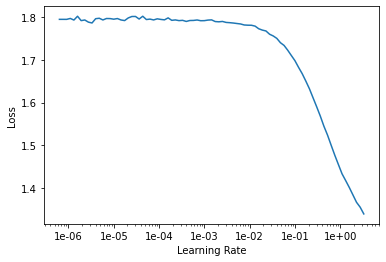

In [ ]:
# hide
from fastai.basics import Learner
from torchlife.losses import hazard_loss
from torchlife.data import get_breakpoints, create_db

df.rename(columns={'week':'t', 'arrest':'e'}, inplace=True)

# event_times = df.loc[df['e']==1, 't'].values
# breakpoints = np.percentile(event_times, [20, 40, 60, 80])
# print(breakpoints)
breakpoints = get_breakpoints(df)
db, t_scaler = create_db(df, breakpoints)

model = PieceWiseHazard(breakpoints, t_scaler)
learner = Learner(db, model, loss_func=hazard_loss)
learner.lr_find()
learner.recorder.plot()

In [ ]:
# hide
epochs = 20
learner.fit(epochs, lr=0.5)

epoch,train_loss,valid_loss,time
0,1.305282,0.723421,00:00
1,0.963033,0.613949,00:00
2,0.836246,0.672900,00:00
3,0.775113,0.740337,00:00
4,0.735887,0.782490,00:00
5,0.710452,0.813484,00:00
6,0.693224,0.824896,00:00
7,0.680480,0.807939,00:00
8,0.668634,0.775585,00:00
9,0.659394,0.741836,00:00


## Plot Hazard Functions

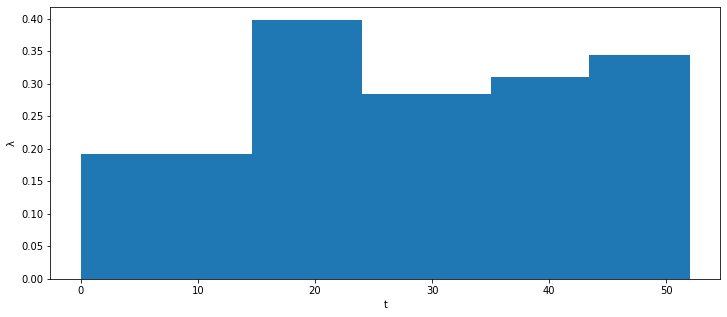

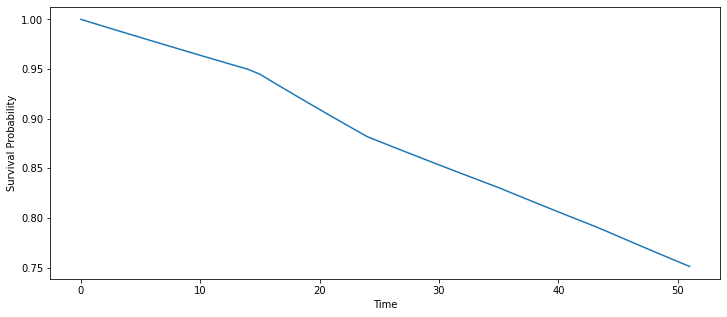

In [ ]:
learner.model.plot_hazard()
learner.model.plot_survival_function(np.arange(df['t'].max()))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_index.ipynb.
Converted 10_SAT.ipynb.
Converted 20_KaplanMeier.ipynb.
Converted 50_hazard.ipynb.
Converted 55_hazard.PiecewiseHazard.ipynb.
Converted 59_hazard.Cox.ipynb.
Converted 60_AFT_models.ipynb.
Converted 65_AFT_error_distributions.ipynb.
Converted 80_data.ipynb.
Converted 90_model.ipynb.
Converted 95_Losses.ipynb.
